# Part 1: Linear Regression with One Feature
## Stellar Luminosity as a Function of Stellar Mass

**Course:** Digital Transformation and Enterprise Architecture - ML Bootcamp

## 1. Setup

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## 2. Dataset and Visualization

Notation:
- $M$: stellar mass (solar masses, $M_\odot$)
- $L$: stellar luminosity (solar luminosities, $L_\odot$)

In [14]:
M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])
m = M.shape[0]

print(f"Number of samples: {m}")

Number of samples: 10


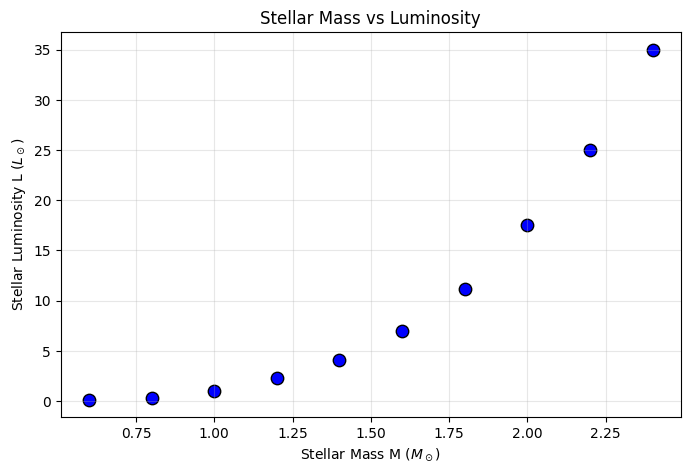

In [15]:
plt.figure(figsize=(8, 5))
plt.scatter(M, L, s=80, c='blue', edgecolors='black')
plt.xlabel('Stellar Mass M ($M_\odot$)')
plt.ylabel('Stellar Luminosity L ($L_\odot$)')
plt.title('Stellar Mass vs Luminosity')
plt.grid(True, alpha=0.3)
plt.show()

**Comment on linearity and plausibility:**

The data shows a clear non-linear relationship. Luminosity increases faster than linearly as mass grows, which is consistent with the known mass-luminosity relation for main-sequence stars ($L \propto M^{3.5}$). A linear model will underestimate luminosity at the extremes and overestimate in the middle range.

## 3. Model and Loss Function

Linear model: $\hat{L} = wM + b$

MSE cost function: $J(w,b) = \frac{1}{2m} \sum_{i=1}^{m} (\hat{L}^{(i)} - L^{(i)})^2$

In [16]:
def predict(M, w, b):
    return w * M + b

def compute_cost(M, L, w, b):
    m = M.shape[0]
    L_hat = w * M + b
    cost = (1 / (2 * m)) * np.sum((L_hat - L) ** 2)
    return cost

print(f"Cost with w=0, b=0: {compute_cost(M, L, 0, 0):.4f}")

Cost with w=0, b=0: 117.6968


## 4. Cost Surface

Evaluating $J(w,b)$ over a grid of values.

In [17]:
w_vals = np.linspace(-5, 30, 100)
b_vals = np.linspace(-30, 10, 100)
W, B = np.meshgrid(w_vals, b_vals)

J_surface = np.zeros_like(W)
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        J_surface[i, j] = compute_cost(M, L, W[i, j], B[i, j])

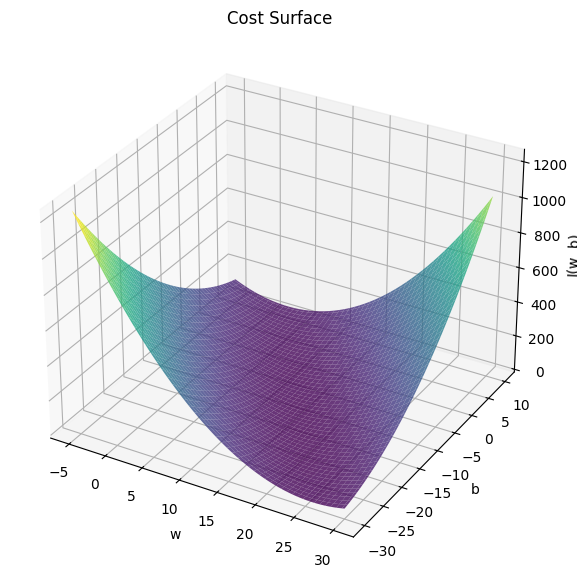

In [18]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W, B, J_surface, cmap='viridis', alpha=0.8)
ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('J(w, b)')
ax.set_title('Cost Surface')
plt.show()

**What does the minimum represent?**

The minimum of the cost surface corresponds to the optimal values of $w$ and $b$ that minimize the prediction error. Since the surface is convex (bowl-shaped), there's a single global minimum, which gradient descent can find reliably.

## 5. Gradients

Partial derivatives:

$$\frac{\partial J}{\partial w} = \frac{1}{m} \sum_{i=1}^{m} (\hat{L}^{(i)} - L^{(i)}) \cdot M^{(i)}$$

$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (\hat{L}^{(i)} - L^{(i)})$$

### 5.1 Non-vectorized (explicit loop)

In [19]:
def compute_gradients_loop(M, L, w, b):
    m = M.shape[0]
    dJ_dw = 0.0
    dJ_db = 0.0
    
    for i in range(m):
        error_i = (w * M[i] + b) - L[i]
        dJ_dw += error_i * M[i]
        dJ_db += error_i
    
    dJ_dw /= m
    dJ_db /= m
    return float(dJ_dw), float(dJ_db)

print("Gradients (loop) at w=0, b=0:", compute_gradients_loop(M, L, 0, 0))

Gradients (loop) at w=0, b=0: (-21.523000000000003, -10.36)


### 5.2 Vectorized (no loop)

In [20]:
def compute_gradients(M, L, w, b):
    m = M.shape[0]
    errors = (w * M + b) - L
    dJ_dw = (1 / m) * np.sum(errors * M)
    dJ_db = (1 / m) * np.sum(errors)
    return dJ_dw, dJ_db

print("Gradients (vectorized) at w=0, b=0:", compute_gradients(M, L, 0, 0))

Gradients (vectorized) at w=0, b=0: (np.float64(-21.523), np.float64(-10.36))


## 6. Gradient Descent

In [21]:
def gradient_descent(M, L, w_init, b_init, alpha, iterations):
    w, b = w_init, b_init
    cost_history = []
    
    for _ in range(iterations):
        dJ_dw, dJ_db = compute_gradients(M, L, w, b)
        w = w - alpha * dJ_dw
        b = b - alpha * dJ_db
        cost_history.append(compute_cost(M, L, w, b))
    
    return w, b, cost_history

## 7. Convergence

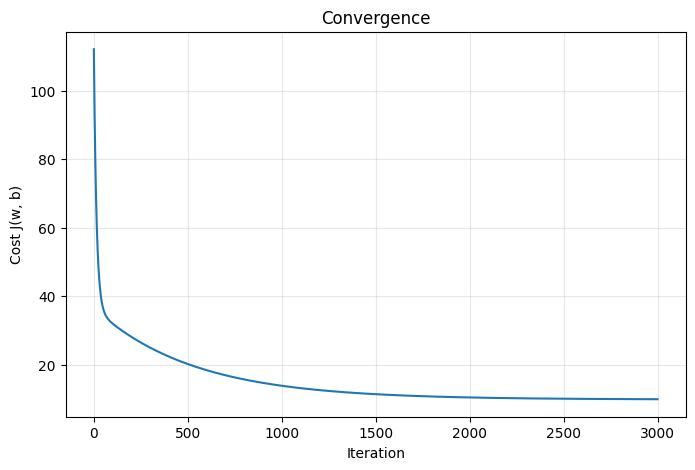

Final: w=17.4136, b=-15.6480, cost=9.8862


In [22]:
w_final, b_final, cost_history = gradient_descent(M, L, 0, 0, alpha=0.01, iterations=3000)

plt.figure(figsize=(8, 5))
plt.plot(cost_history)
plt.xlabel('Iteration')
plt.ylabel('Cost J(w, b)')
plt.title('Convergence')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final: w={w_final:.4f}, b={b_final:.4f}, cost={cost_history[-1]:.4f}")

**Comment on convergence:**

With $\alpha = 0.01$, the cost decreases rapidly in the first few hundred iterations and then stabilizes. The algorithm converges smoothly without oscillations, indicating a stable learning rate.

## 8. Learning Rate Experiments

In [23]:
learning_rates = [0.001, 0.01, 0.05]

print(f"{'Alpha':<10} {'w':<12} {'b':<12} {'Final Cost':<12}")
print("-" * 46)

for alpha in learning_rates:
    w, b, history = gradient_descent(M, L, 0, 0, alpha, 2000)
    print(f"{alpha:<10} {w:<12.4f} {b:<12.4f} {history[-1]:<12.4f}")

Alpha      w            b            Final Cost  
----------------------------------------------
0.001      7.9562       0.0096       28.1290     
0.01       16.2822      -13.7735     10.4007     
0.05       18.1294      -16.8339     9.7951      


## 9. Final Fit

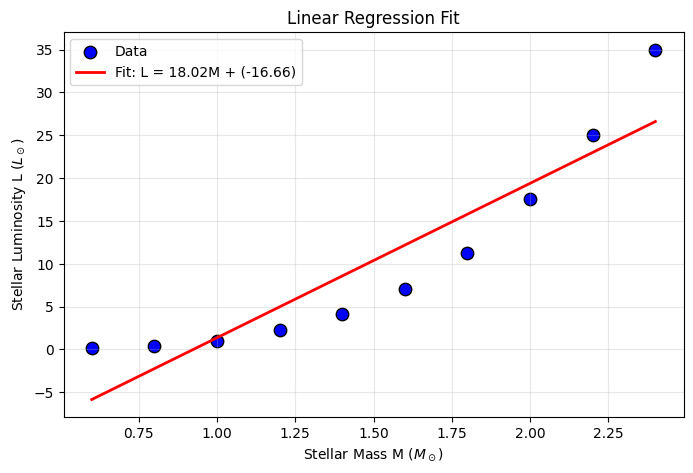

In [24]:
w_best, b_best, _ = gradient_descent(M, L, 0, 0, 0.01, 5000)
L_pred = predict(M, w_best, b_best)

plt.figure(figsize=(8, 5))
plt.scatter(M, L, s=80, c='blue', edgecolors='black', label='Data')
plt.plot(M, L_pred, 'r-', linewidth=2, label=f'Fit: L = {w_best:.2f}M + ({b_best:.2f})')
plt.xlabel('Stellar Mass M ($M_\odot$)')
plt.ylabel('Stellar Luminosity L ($L_\odot$)')
plt.title('Linear Regression Fit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Systematic errors:**

The linear fit overestimates luminosity for low-mass stars and underestimates it for high-mass stars. This pattern occurs because the true relationship is nonlinear (curved upward), but our model can only produce a straight line.

## 10. Conceptual Questions

**1. Astrophysical meaning of $w$:**

The slope $w \approx 18$ represents how much luminosity increases per unit increase in stellar mass. In our linear approximation, for every additional solar mass, luminosity increases by about 18 solar luminosities. This is an "average" rate of change across our data range.

**2. Why is a linear model limited here?**

Stellar luminosity follows a power law ($L \propto M^{3.5}$), not a linear relationship. This comes from the physics of nuclear fusion: more massive stars have higher core temperatures and pressures, which increases fusion rates nonlinearly. A straight line cannot capture this curvature, resulting in systematic prediction errors.